In [10]:
import numpy as np
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
import scipy
import skimage as sk
import skimage.io as skio
from skimage import color
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import h5py
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten, Reshape, Dropout
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import SGD, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Input
from PIL import Image
import math
from tensorflow.python.client import device_lib
%matplotlib inline

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10707231502854211122
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 228458496
locality {
  bus_id: 1
}
incarnation: 6286343074549233387
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


## Load Datasets

In [2]:
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = mnist.load_data()
encoder = OneHotEncoder()
mnist_y_train = encoder.fit_transform(mnist_y_train[:, None]).todense()
mnist_y_test = encoder.fit_transform(mnist_y_test[:, None]).todense()

svhn_train = scio.loadmat('svhn_train.mat')
svhn_test = scio.loadmat('svhn_test.mat')
svhn_X_train = svhn_train['X']
svhn_y_train = svhn_train['y']
svhn_X_test = svhn_test['X']
svhn_y_test = svhn_test['y']
svhn_X_train = np.array([svhn_X_train[:, :, :, i] for i in range(svhn_X_train.shape[-1])])
svhn_X_test = np.array([svhn_X_test[:, :, :, i] for i in range(svhn_X_test.shape[-1])])
svhn_y_train = encoder.fit_transform(svhn_y_train).todense()
svhn_y_test = encoder.fit_transform(svhn_y_test).todense()

## FGAN

In [3]:
def classifier(pretrain=True):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same'))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    if pretrain:
        model.add(Conv2D(10, (7, 7)))
        model.add(Activation('softmax'))
        model.add(Flatten())
    return model
    
def generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same'))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

def discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(1, (4, 4), padding='same', kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

def generator_with_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

## Pretraining

In [13]:
c = classifier()
c.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [14]:
def resize_images(imgs):
    return np.array([sk.img_as_float(scipy.misc.imresize(img.reshape(28, 28), (32, 32))) for img in imgs])

def stack_and_resize_mnist(mnist_X):
    resized_mnist_X = resize_images(mnist_X).reshape(mnist_X.shape[0], 32, 32, 1)
    stacked_mnist_X = np.stack((resized_mnist_X, resized_mnist_X, resized_mnist_X), axis=3).reshape(resized_mnist_X.shape[0], 32, 32, 3)
    return stacked_mnist_X

In [15]:
stacked_mnist_X_train = stack_and_resize_mnist(mnist_X_train)
stacked_mnist_X_test = stack_and_resize_mnist(mnist_X_test)

In [16]:
X_train = np.vstack((stacked_mnist_X_train, svhn_X_train))
X_test = np.vstack((stacked_mnist_X_test, svhn_X_test))
y_train = np.vstack((mnist_y_train, svhn_y_train))
y_test = np.vstack((mnist_y_test, svhn_y_test))

In [12]:
c.fit(X_train, y_train, epochs=2)

Epoch 1/2
133257/133257 [==============================] - 22s - loss: 0.3141 - acc: 0.9051     

In [13]:
c.evaluate(X_test, y_test)

35712/36032 [============================>.] - ETA: 0s

[0.62354514085117341, 0.80170404085257552]

## Training

In [25]:
def loss_function(inputs, generator, classifier, batch_size):
    class_true = classifier.predict(inputs)
    def loss(y_true, y_pred):
        indices = np.random.randint(inputs.shape[0], size=batch_size)
        batch_class_true = class_true[indices]
        batch = inputs[indices]
        preds = resize_images(generator.predict(batch, verbose=0))
        stacked_preds = np.stack((preds, preds, preds), axis=3).reshape(preds.shape[0], 32, 32, 3)
        class_pred = classifier.predict(stacked_preds)
        loss_gan = keras.losses.mean_squared_error(y_true, y_pred)
        loss_const = keras.losses.mean_squared_error(batch_class_true, class_pred)
        return loss_gan + 15 * loss_const
    return loss
# def loss_function(inputs, generator, classifier):
# #     class_true = classifier.predict(inputs)
#     def loss(y_true, y_pred):
# #         preds = resize_images(generator.predict(inputs, verbose=0))
# #         stacked_preds = np.stack((preds, preds, preds), axis=3).reshape(preds.shape[0], 32, 32, 3)
# #         class_pred = classifier.predict(stacked_preds)
#         loss_gan = keras.losses.mean_squared_error(y_true, y_pred)
# #         loss_const = keras.losses.mean_squared_error(class_true, class_pred)
#         return loss_gan 
#     return loss

def train(mnist_X_train, svhn_X_train, g=None, d=None, c=c, batch_size=128, epochs=100):
    mnist_X_train = (mnist_X_train.astype(np.float32) - 127.5)/127.5
    svhn_X_train = (svhn_X_train.astype(np.float32) - 127.5)/127.5
    if not g: g = generator()
    if not d: d = discriminator()
    g_d = generator_with_discriminator(g, d)
    g_d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_d_loss = loss_function(svhn_X_train, g, c, batch_size)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g_d.compile(loss=g_d_loss, optimizer=g_d_optim)
    d.trainable = True
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for e in range(epochs):
        print('Epoch: {}'.format(e))
        for i in range(int(mnist_X_train.shape[0] / batch_size)):
            # Create batches
            batch_mnist_X = mnist_X_train[np.random.randint(mnist_X_train.shape[0], size=batch_size)]
            batch_svhn_X = svhn_X_train[np.random.randint(svhn_X_train.shape[0], size=batch_size)]
            
            # Generate MNIST examples from noise for training
            g_train_data = g.predict(batch_svhn_X, verbose=0)
            
            # Label as real or fake
            y_real, y_fake = np.ones(batch_size), np.zeros(batch_size)
            X_train, y_train = np.vstack((batch_mnist_X, g_train_data)), np.hstack((y_real, y_fake))
            
            # Train discriminator on this real/fake data
            d_loss = d.train_on_batch(X_train, y_train)
            
            # Train generator based on the outputs of the discriminator
            batch_svhn_X = svhn_X_train[np.random.randint(svhn_X_train.shape[0], size=batch_size)]
            
            d.trainable = False
            g_loss = g_d.train_on_batch(batch_svhn_X, np.ones(batch_svhn_X.shape[0]))
            d.trainable = True
            if i % 100 == 99:
                print('Iteration {}'.format(i))
                print('D Loss:', d_loss)
                print('G Loss:', g_loss)
# #                 g.save_weights('G.h5')
#                 d.save_weights('D.h5')
    return g, d

def test_pred(g, d):
    g_images = g.predict(svhn_X_train[np.random.randint(svhn_X_train.shape[0], size=10)])
    g_images = g_images * 127.5 + 127.5
    for i in range(10):
        plt.figure()
        plt.figure()
        plt.imshow(g_images[i][:, :, 0], cmap='gray')
    print(d.predict(g_images))

In [27]:
g, d = train(mnist_X_train[:, :, :, None], svhn_X_train, epochs=10)

Epoch: 0
Iteration 99
D Loss: 0.5661
G Loss: 1.42833
Iteration 199
D Loss: 0.571988
G Loss: 1.45853
Iteration 299
D Loss: 0.559543
G Loss: 1.4865
Iteration 399
D Loss: 0.538941
G Loss: 1.49933
Epoch: 1
Iteration 99
D Loss: 0.527715
G Loss: 1.52779
Iteration 199
D Loss: 0.511139
G Loss: 1.52339
Iteration 299
D Loss: 0.534976
G Loss: 1.52716
Iteration 399
D Loss: 0.526467
G Loss: 1.52599
Epoch: 2
Iteration 99
D Loss: 0.538708
G Loss: 1.53842
Iteration 199
D Loss: 0.529656
G Loss: 1.54459
Iteration 299
D Loss: 0.533064
G Loss: 1.5492
Iteration 399
D Loss: 0.53525
G Loss: 1.54031
Epoch: 3
Iteration 99
D Loss: 0.545391
G Loss: 1.56319
Iteration 199
D Loss: 0.553571
G Loss: 1.54918
Iteration 299
D Loss: 0.58288
G Loss: 1.54459
Iteration 399
D Loss: 0.570391
G Loss: 1.55438
Epoch: 4
Iteration 99
D Loss: 0.565496
G Loss: 1.56613
Iteration 199
D Loss: 0.582478
G Loss: 1.57902
Iteration 299
D Loss: 0.563098
G Loss: 1.5664
Iteration 399
D Loss: 0.599635
G Loss: 1.59143
Epoch: 5
Iteration 99
D Los

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


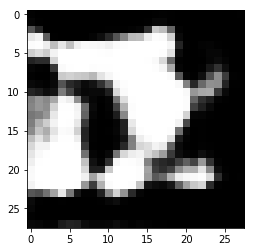

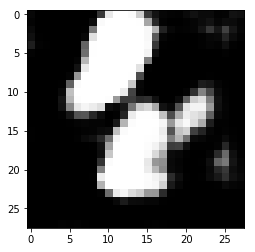

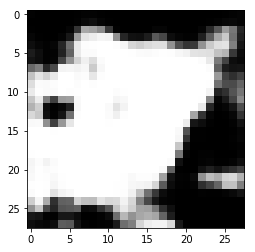

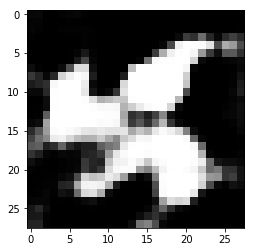

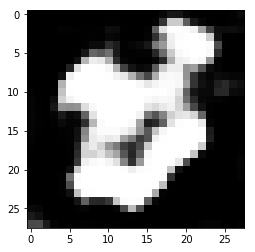

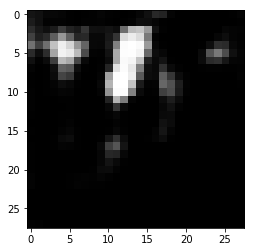

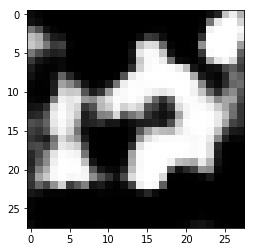

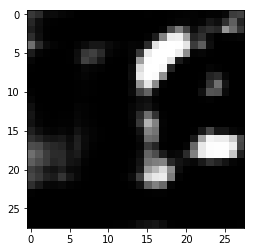

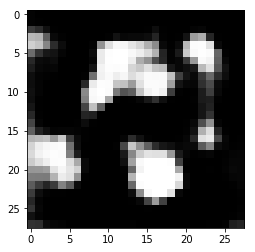

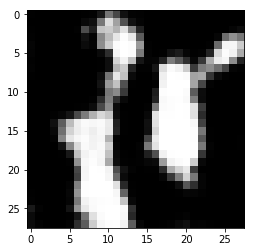

In [28]:
test_pred(g, d)